We first import the necessary libraries. 

In [1]:
import torch
import os, sys
from torch import nn
import math
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import mosek
from scipy.stats import chi2

We next define the discriminator neural network.

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(201, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In this example, we consider the following data generative law:
$$\eta(x)=1/(1+\exp (-x^T\theta_0))\,, \quad \theta_0 \sim \mathsf{N}(0,I_{200})\,, \quad \theta_1=-2\theta_0\,.$$
We train the network by 64k input samples.

In [3]:
torch.manual_seed(111)
d=200 ##number of features
th0=torch.normal(0,1,[d,1])
th1=-2*th0
train_data_length = 4096*16 ##number of training samples to train the discriminator
feature_data=torch.normal(0,1,[train_data_length,d]) ## feature vectors x
heta_val=1/(1+torch.exp(feature_data@th1))
eta_val=1/(1+torch.exp(feature_data@th0))
label_data = (torch.rand([train_data_length, 1]) <eta_val).long() ## label values y
tmp=torch.rand([train_data_length,1])
w = 2 * tmp * label_data* heta_val - label_data * heta_val - tmp * heta_val - label_data * tmp + tmp + heta_val
train_data=torch.cat((feature_data,w),1)
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
    )
discriminator = Discriminator()
lr = 0.001 ##learning rate
num_epochs = 100
loss_function = nn.BCELoss() ##binary cross entropy loss
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1)) ###real samples are labeled one
        generated_features=torch.normal(0,1,[batch_size,d])
        generated_unif=torch.rand([batch_size,1])
        generated_samples = torch.cat((generated_features,generated_unif),1)
        generated_samples_labels = torch.zeros((batch_size, 1))  ## generated samples are labeled zero
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

            # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()


            # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")


    
    

Epoch: 0 Loss D.: 0.6938138604164124
Epoch: 10 Loss D.: 0.17667104303836823
Epoch: 20 Loss D.: 0.1493140459060669
Epoch: 30 Loss D.: 0.15186679363250732
Epoch: 40 Loss D.: 0.16040094196796417
Epoch: 50 Loss D.: 0.15120142698287964
Epoch: 60 Loss D.: 0.19318166375160217
Epoch: 70 Loss D.: 0.08731723576784134
Epoch: 80 Loss D.: 0.16278113424777985
Epoch: 90 Loss D.: 0.09410787373781204


## Total variation
To evaluate the performance of the discriminator network, We plot the histogram of discriminator output values for inputs of original $(x,w)$ and counterfeit samples $(\widetilde{x},\widetilde{w})$.

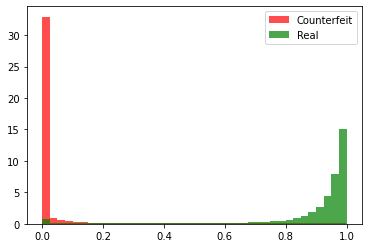

In [4]:
###Evaluating the discriminator performance
test_size = 100000
test_feature_data = torch.normal(0, 1, [test_size, d])
test_feature_data_2 = torch.normal(0, 1, [test_size, d])
test_heta_val = 1 / (1 + torch.exp(test_feature_data @ th1))
test_eta_val = 1 / (1 + torch.exp(test_feature_data @ th0))
test_label_data = (torch.rand([test_size, 1]) < test_eta_val).long()
tmp = torch.rand([test_size, 1])
test_w = 2 * tmp * test_label_data * test_heta_val - test_label_data * test_heta_val - tmp * test_heta_val - test_label_data * tmp + tmp + test_heta_val
test_data = torch.cat((test_feature_data, test_w), 1)
fake_data = torch.cat((test_feature_data_2, torch.rand(test_size, 1)), 1)
num_bins = 40
##fake data in green
plt.hist(np.array(discriminator(fake_data).detach()), num_bins,
         density=1,
         color='red',
         alpha=0.7,
        label='Counterfeit')

plt.hist(np.array(discriminator(test_data).detach()), num_bins,
         density=1,
         color='green',
         alpha=0.7,
        label='Real')
plt.legend(loc='upper right')
plt.show()

We next proceed to the main hypothesis testing problem for the total variation as the f-divergence function. We consider two score functions, the GAN-based and the model agnostic score function.  

In [5]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=10
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000

reject_tv_asym=0
reject_tv_finite=0

reject_tv_asym_agn=0
reject_tv_finite_agn=0
tau_vals=np.arange(0.5,0.9,0.01)

result_tv_asym=np.zeros(0)
result_tv_finite=np.zeros(0)
result_tv_asym_agn=np.zeros(0)
result_tv_finite_agn=np.zeros(0)


for tau in tau_vals: 
    reject_tv_asym=0
    reject_tv_asym_agn=0
    reject_tv_finite=0
    reject_tv_finite_agn=0
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_agn=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_agn=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_agn=torch.sum( (original_scores_agn > counterfeit_scores_agn).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_agn=torch.floor(rank_val_agn / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_agn = labels_agn.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_agn=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_agn[ell]=np.sum(my_label_agn == (ell + 1))
        ##tv_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_tv_asym>=chi2.ppf(1-alpha, L-1):
            reject_tv_asym=reject_tv_asym+1
        ##tv_asym_agn
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_agn, V_agn)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_asym = (1 / n) * np.sum(((V_agn - n * my_p.value) ** 2) / my_p.value)
        if T_tv_asym>=chi2.ppf(1-alpha, L-1):
            reject_tv_asym_agn=reject_tv_asym_agn+1
        
        
        ##tv_finite
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
                obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
        if T_tv_finite>=L+np.sqrt(2*L/alpha):
            reject_tv_finite=reject_tv_finite+1
        ##tv_finite_agn
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
            obj=obj+(1/L)*cp.quad_over_lin(V_agn[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.norm(my_p - 1 / L, 1) <= 2 * tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_tv_finite = (1 / n) * np.sum(((V_agn - n * my_p.value) ** 2) /(my_p.value+1/L))
        if T_tv_finite>=L+np.sqrt(2*L/alpha):
            reject_tv_finite_agn=reject_tv_finite_agn+1
        
    result_tv_asym=np.append(result_tv_asym,reject_tv_asym/N_exp)
    result_tv_asym_agn=np.append(result_tv_asym_agn,reject_tv_asym_agn/N_exp)
    result_tv_finite=np.append(result_tv_finite,reject_tv_finite/N_exp)
    result_tv_finite_agn=np.append(result_tv_finite_agn,reject_tv_finite_agn/N_exp)
    
            

    
    

        
        
    

    




    
















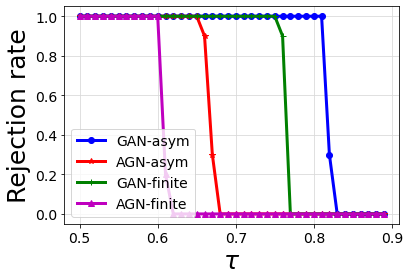

In [6]:
tau_vals=np.arange(0.5,0.9,0.01)
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)   
plt.plot(tau_vals,result_tv_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_tv_asym_agn,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_tv_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_tv_finite_agn,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
plt.show()


## Helinger distance


In [7]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=10
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000






reject_hlg_asym=0
reject_hlg_finite=0

reject_hlg_asym_agn=0
reject_hlg_finite_agn=0

tau_vals=np.linspace(0.3, 1.10,81)

result_hlg_asym=np.zeros(0)
result_hlg_finite=np.zeros(0)
result_hlg_asym_agn=np.zeros(0)
result_hlg_finite_agn=np.zeros(0)


for tau in tau_vals: 
    reject_hlg_asym=0
    reject_hlg_asym_agn=0
    reject_hlg_finite=0
    reject_hlg_finite_agn=0
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_agn=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_agn=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_agn=torch.sum( (original_scores_agn > counterfeit_scores_agn).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_agn=torch.floor(rank_val_agn / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_agn = labels_agn.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_agn=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_agn[ell]=np.sum(my_label_agn == (ell + 1))
        ##hlg_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_hlg_asym>=chi2.ppf(1-alpha, L-1):
            reject_hlg_asym=reject_hlg_asym+1
        ##hlg_asym_agn
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_agn, V_agn)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_asym = (1 / n) * np.sum(((V_agn - n * my_p.value) ** 2) / my_p.value)
        if T_hlg_asym>=chi2.ppf(1-alpha, L-1):
            reject_hlg_asym_agn=reject_hlg_asym_agn+1
        
        
        ##hlg_finite
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
                obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
        if T_hlg_finite>=L+np.sqrt(2*L/alpha):
            reject_hlg_finite=reject_hlg_finite+1
        ##hlg_finite_agn
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
            obj=obj+(1/L)*cp.quad_over_lin(V_agn[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.sqrt(my_p))>= cp.sqrt(L) * (1-tau/2)]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_hlg_finite = (1 / n) * np.sum(((V_agn - n * my_p.value) ** 2) /(my_p.value+1/L))
        if T_hlg_finite>=L+np.sqrt(2*L/alpha):
            reject_hlg_finite_agn=reject_hlg_finite_agn+1
        
    result_hlg_asym=np.append(result_hlg_asym,reject_hlg_asym/N_exp)
    result_hlg_asym_agn=np.append(result_hlg_asym_agn,reject_hlg_asym_agn/N_exp)
    result_hlg_finite=np.append(result_hlg_finite,reject_hlg_finite/N_exp)
    result_hlg_finite_agn=np.append(result_hlg_finite_agn,reject_hlg_finite_agn/N_exp)
    
            
        

    
    
    
    
    

        
        
    

    




    
















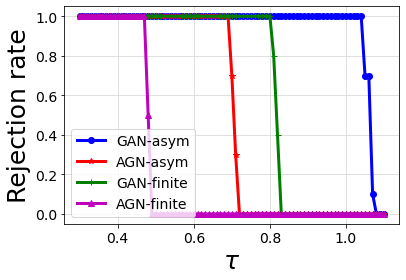

In [8]:
tau_vals=0.01*np.arange(30,111,1)
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)     
plt.plot(tau_vals,result_hlg_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_hlg_asym_agn,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_hlg_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_hlg_finite_agn,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
plt.show()
    
    
    

## KL-divergence

In [9]:
#computing test statistic V
torch.manual_seed(111)
alpha=0.1
N_exp=10
flag=0
K = 1
L = 50
M = K * L - 1
n = 5000






reject_kl_asym=0
reject_kl_finite=0
reject_kl_asym_agn=0
reject_kl_finite_agn=0
tau_vals=np.linspace(0.2, 2.6,81)

result_kl_asym=np.zeros(0)
result_kl_finite=np.zeros(0)
result_kl_asym_agn=np.zeros(0)
result_kl_finite_agn=np.zeros(0)

tau_vals=np.linspace(0.2, 2.6,81)
for tau in tau_vals: 
    reject_kl_asym=0
    reject_kl_asym_agn=0
    reject_kl_finite=0
    reject_kl_finite_agn=0
    for counter in range(N_exp): 
        X = torch.normal(0, 1, [n, d])
        heta_val = 1 / (1 + torch.exp(X @ th1))
        eta_val = 1 / (1 + torch.exp(X @ th0))
        Y = (torch.rand([n, 1]) < eta_val).long()
        tmp = torch.rand([n, 1])
        w = 2 * tmp * Y * heta_val - Y * heta_val - tmp * heta_val - Y * tmp + tmp + heta_val
        original_scores = discriminator(torch.cat((X, w), 1))
        original_scores_agn=(w <= heta_val).long() * 0.5 / heta_val + (w >= heta_val).long() * (0.5) / (1-heta_val)
        counterfeit_scores = torch.squeeze(
            torch.stack([discriminator(torch.cat((torch.normal(0, 1, [M, d]), torch.rand(M, 1)), 1)) for i in range(n)]))
        heta_val_c=torch.squeeze(
        torch.stack( [1/(1+torch.exp(torch.normal(0, 1, [M, d])@th1)) for i in range(n) ] ))
        w_c=torch.rand(n, M)
        counterfeit_scores_agn=(w_c <= heta_val_c).long() * 0.5 / heta_val_c + (w_c >= heta_val_c).long() * (0.5) / (1-heta_val_c)
        rank_val = torch.sum( (original_scores > counterfeit_scores).long(), 1)
        rank_val_agn=torch.sum( (original_scores_agn > counterfeit_scores_agn).long(), 1)
        labels = torch.floor(rank_val / K) + 1;
        labels_agn=torch.floor(rank_val_agn / K) + 1;
        my_label = labels.cpu().detach().numpy().astype(int)
        my_label_agn = labels_agn.cpu().detach().numpy().astype(int)
        V = np.zeros(L).astype(int)
        V_agn=np.zeros(L).astype(int)
        for ell in range(L):
            V[ell] = np.sum(my_label == (ell + 1))
            V_agn[ell]=np.sum(my_label_agn == (ell + 1))
        ##kl_asym
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V, V)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym=reject_kl_asym+1
        ##kl_asym_agn
        my_p = cp.Variable(L)
        objective = cp.Minimize(-n + cp.sum(cp.multiply(cp.inv_pos(my_p), cp.multiply(V_agn, V_agn)) / n))
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_asym = (1 / n) * np.sum(((V_agn - n * my_p.value) ** 2) / my_p.value)
        if T_kl_asym>=chi2.ppf(1-alpha, L-1):
            reject_kl_asym_agn=reject_kl_asym_agn+1
        
        
        ##kl_finite
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
                obj=obj+(1/L)*cp.quad_over_lin(V[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_finite = (1 / n) * np.sum(((V - n * my_p.value) ** 2) / (my_p.value+1/L))
        if T_kl_finite>=L+np.sqrt(2*L/alpha):
            reject_kl_finite=reject_kl_finite+1
        ##kl_finite_agn
        my_p = cp.Variable(L)
        obj=0
        for i in range(L):
            obj=obj+(1/L)*cp.quad_over_lin(V_agn[i]/n-my_p[i], 1/L + my_p[i] )
        objective = cp.Minimize(obj)
        constraints = [0 <= my_p, cp.sum(my_p) == 1, cp.sum(cp.entr(my_p))>=cp.log(L)-tau]
        prob = cp.Problem(objective, constraints)
        result = prob.solve(solver='MOSEK', verbose=False)
        if(prob.status != 'optimal'):
            falg=1
        T_kl_finite = (1 / n) * np.sum(((V_agn - n * my_p.value) ** 2) /(my_p.value+1/L))
        if T_kl_finite>=L+np.sqrt(2*L/alpha):
            reject_kl_finite_agn=reject_kl_finite_agn+1
        
    result_kl_asym=np.append(result_kl_asym,reject_kl_asym/N_exp)
    result_kl_asym_agn=np.append(result_kl_asym_agn,reject_kl_asym_agn/N_exp)
    result_kl_finite=np.append(result_kl_finite,reject_kl_finite/N_exp)
    result_kl_finite_agn=np.append(result_kl_finite_agn,reject_kl_finite_agn/N_exp)
    
            
        

    
    
    
    
    
    

        
        
    

    




    
















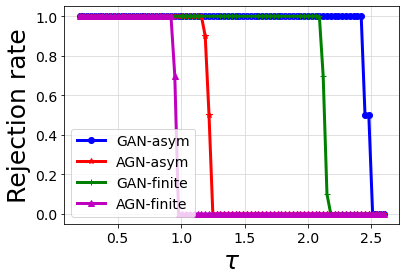

In [10]:
plt.rc('axes', labelsize=25)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
   
plt.plot(tau_vals,result_kl_asym,'bo-',label='GAN-asym',linewidth=3)
plt.plot(tau_vals,result_kl_asym_agn,'r*-',label='AGN-asym',linewidth=3)
plt.plot(tau_vals,result_kl_finite,'g+-',label='GAN-finite',linewidth=3)
plt.plot(tau_vals,result_kl_finite_agn,'m^-',label='AGN-finite',linewidth=3)
plt.legend(loc='lower left')
plt.grid(axis='x', color='0.85')
plt.grid(axis='y', color='0.85')
plt.xlabel(r'$\tau$')
plt.ylabel('Rejection rate')
plt.show()
    